# **Placing Semi-Landmarks**

In [53]:
# import logging
# mpl_logger = logging.getLogger('matplotlib')
# mpl_logger.setLevel(logging.WARNING) 

### General Imports
# import matplotlib.pyplot as plt
from glob import glob as glob
import numpy as np
import pandas as pd
import os
from tqdm.notebook import tqdm
import pyvista as pv
from plotly.subplots import make_subplots
import plotly.graph_objects as go

from IPython.display import Image

import sys
sys.path.insert(0, '/Users/veronika/Code/chindef/')
from chindef.systemsetup import systemsetup_sinope as systemsetup
import chindef.utils.eval_utils as eutils
import chindef.utils.class_utils as cutils

info_file = systemsetup.INFO_FILE

data = 'simplified0.3'

DATA_DIR = "{}/{}".format(systemsetup.DATA_DIR, data)
OUT_DIR = '{}/{}-semi_landmarks/GeodesicFromCurves'.format(systemsetup.DATA_DIR, data)

if not os.path.exists(OUT_DIR):
    os.makedirs(OUT_DIR)

saveit = False

dim = 3

### **Info about specimen**

In [54]:
df = eutils.read_data(info_file, sheet='all_specimen')
specimen = list(df['specimen'])

df.head(5)

,ids,Group_ids,Group_names,specimen,age,age_in_years,age_in_days,sex,sexEnc,Group_ids_2,Group_names_2
0,1,0,European,embr_EMBR119,6y,6.000000,2190.0,M,0.0,0,European_male
1,2,0,European,embr_EMBR121,5y,5.000000,1825.0,F,1.0,1,European_female
2,3,0,European,embr_EMBR136,6y,6.000000,2190.0,M,0.0,0,European_male
3,4,0,European,embr_EMBR180,10m,0.835616,305.0,F,1.0,1,European_female
4,5,0,European,embr_EMBR201,3y7m,3.586301,1309.0,M,0.0,0,European_male


### **Functions to extract the semi-LMs on surfaces**

In [44]:
from scipy.spatial import distance_matrix, distance

"""
    Sort the points in the curve
    - find starting point
    - get the shortest path sequence
    - reorder points accordingly
    """
def shortest_path(mesh):
    points = mesh.points

    # pairwise point distances
    mat_dist = distance.cdist(points, points, 'euclidean')
    df_mat_dist = pd.DataFrame(mat_dist)

    # find starting point 
    # first point is in lower left corner -> smallest x, smallest y -> smallest norm
    point_norms = np.linalg.norm(points, axis=1)
    closest_idx = np.argmin(point_norms)
    path_points = [closest_idx]

    # Shortest path + path length
    #Find the closest point to the starting point, different from diagonal and save results
    path_length = 0
    for _ in range(points.shape[0]-1):
        closest_dist = df_mat_dist.loc[closest_idx, ~df_mat_dist.index.isin(path_points)].min()
        closest_idx = df_mat_dist.loc[closest_idx, ~df_mat_dist.index.isin(path_points)].idxmin()
        path_points.append(closest_idx)
        path_length += closest_dist

    return points[path_points,:], path_length

"""
    Two ways to extract the semi-Landmarks
    'distance'  :   select LMs uniformly distributed over curve length
    'sampling'  :   select every Nth point
"""
def sample_curve(mesh, N, type='distance'):

    # points = mesh.points

    #
    # Reorder points so that they represent the shortest path from starting to end point of the curve
    points, length = shortest_path(mesh)
    # print(f'Length of curve: {length}')
    Npoints = points.shape[0]

    if type == 'distance':

        # get uniform distance of N sampled points
        dist = length / (N-1)
        # print(f'Distance of sampling poins: {dist}')

        # collect the starting and end point as first semi-Landmarks
        samples = np.zeros((N,3))
        samples[0,:] = points[0,:]
        samples[-1,:] = points[-1,:]

        # get samples over the distances
        ref = points[0,:]
        count = 0
        for i in range(2,Npoints-1):
            # distances of this and previous point
            d1 = distance.euclidean(ref, points[i-1,:])
            d2 = distance.euclidean(ref, points[i,:])
            
            # if the distance to this point is larger than the sampling distance 'dist',
            # -> we found a next semi-LM!
            if d2>dist:
                # check if this or the previous point is closer to desired distance 
                # 'dist' of the previously selected LM.
                s = np.argmin([abs(d1-dist), abs(d2-dist)])
                count += 1
                # if s==0:  ref = points[i-1,:]
                # else:     ref = points[i,:]
                ref = points[i+s-1,:]
                samples[count,:] = ref
    elif type=='sampling':

        # I can't ensure that the last point of the curve is part of the semi-LM set

        # just take every Nth sample
        samples = points[::N,:]

    return samples

In [45]:
# Plotting

def plot_landmarks(meshes, curves, titles, specs, pfile=None, isLM=False, show=False):
    M = len(meshes)
    N = len(curves)
    fig = make_subplots(rows=1, cols=M, subplot_titles=titles, specs=specs)

    colors = ['red', 'coral', 'orange', 'gold', 'yellow', 'greenyellow', 'green', 'aquamarine']

    for m in range(M):
        # Add traces
        # subplot 1
        fig.add_trace(go.Scatter3d(x=meshes[m].points[:,0], y=meshes[m].points[:,1], z=meshes[m].points[:,2], 
                            mode='markers', marker=dict(color='blue', opacity=0.1, size=2),name='Surface')
                            , row=1, col=m+1)

        
        for n in range(N):
            if not isLM:

                fig.add_trace(go.Scatter3d(x=curves[n].points[:,0], y=curves[n].points[:,1], z=curves[n].points[:,2], 
                                    mode='markers', marker=dict(color=colors[n],),name='Curve')
                                    , row=1, col=m+1)
            else:

                fig.add_trace(go.Scatter3d(x=curves[n][:,0], y=curves[n][:,1], z=curves[n][:,2], 
                            mode='markers', marker=dict(color=colors[n]),name='Semi-LMs'), row=1, col=m+1)

    fig.update_layout(height=600, width=M*600, title_text='')
    if pfile is not None:
        fig.write_image(pfile)
    if show:
        fig.show()

### **Examplary LM extraction on EMBR388**

In [46]:
N = [15,8]
N = [10,6]

mesh_file = f'{DATA_DIR}/embr_EMBR388.vtk'
mesh_file = f'{DATA_DIR}/ctdsc_138-ROS0299.vtk'
mesh_file = f'{DATA_DIR}/fos_KW-6420.vtk'
mesh_file = f'{DATA_DIR}/embr_EMBR213.vtk'



mesh = pv.read(mesh_file)

# p1 = np.asarray([45.9594, 63.4032, 13.0612])
# p2 = np.asarray([41.4059, 62.5308, 9.64414])

# p3 = np.asarray([45.9969, 63.4614, 13.0612])
# p4 = np.asarray([41.4059, 62.5038, 9.64414])
# p5 = np.asarray([41.5453, 61.1145, 9.35905])
# p6 = np.asarray([41.5279, 61.2299, 9.40146])
# p1i = mesh.find_closest_point(p1)
# mesh, i = mesh.remove_points(p1i)
# p2i = mesh.find_closest_point(p2)
# mesh, i = mesh.remove_points(p2i)
# p3i = mesh.find_closest_point(p3)
# mesh, i = mesh.remove_points(p3i)
# p4i = mesh.find_closest_point(p4)
# mesh, i = mesh.remove_points(p4i)
# p5i = mesh.find_closest_point(p5)
# mesh, i = mesh.remove_points(p5i)
# p6i = mesh.find_closest_point(p6)
# mesh, i = mesh.remove_points(p6i)

# mesh.save(f'{DATA_DIR}/embr_EMBR213.vtk')

# print(i)

curves = mesh.slice_along_axis(n=N[1],axis='y')

semiLMs = []
for n in range(N[1]):
    semiLMs.append(sample_curve(curves[n], N[0], type='distance'))

plot_landmarks([mesh], curves, ('surface'), [[{'type': 'scatter3d'}]], isLM=False, pfile=None, show=True)
plot_landmarks([mesh], semiLMs, ('surface'), [[{'type': 'scatter3d'}]], isLM=True, pfile=None, show=True)



--------------------------------
### **Extract semi-LMs**

method: 'distance'

In [62]:
N = [15,8] # [10,6], [15,8]
Nr_SLM = N[0]*N[1] 

OUT_N_DIR = f'{OUT_DIR}/{Nr_SLM}'
if not os.path.exists(OUT_N_DIR):
    os.makedirs(OUT_N_DIR)

# directory for .png files to check the landmark placement
if not os.path.exists(OUT_N_DIR+'/check'):
    os.makedirs(OUT_N_DIR+'/check')

In [49]:
semi_landmarks = np.zeros((len(specimen),dim*Nr_SLM))

for si, spec in tqdm(enumerate(specimen)):

    # if not si==11:
        # print(spec)
        # continue
    continue
    # print(spec)
    """
        Read original curve
    """
    # print("{}/{}.vtk".format(DATA_DIR, spec))
    mesh = pv.read("{}/{}.vtk".format(DATA_DIR, spec))

    """
        Extract semi-LMs
    """
    # slice mesh along axis to get N[1] curves
    curves = mesh.slice_along_axis(n=N[1],axis='y')
    # Get equidistantly spaced landmarks for each of the curves
    semiLMs = []
    for n in range(N[1]):
        semiLMs.append(sample_curve(curves[n], N[0], type='distance'))
    # print(f'Number of semi-LMs: {semiLMs.shape[0]}')

    """
        Save points
    """
    for n in range(N[1]):
        # print(semiLMs[n].shape)
        semiL = np.reshape(semiLMs[n], (1,-1))
        # print(semiL.shape)
        # print(semi_landmarks[si,n*N[0]*3:(n+1)*N[0]*3].shape)
        semi_landmarks[si,n*N[0]*3:(n+1)*N[0]*3] = semiL

    """
        Visualization
    """
    # plot_landmarks([mesh], curves, ('surface'), [[{'type': 'scatter3d'}]], isLM=False, pfile=None, show=True)
    plot_landmarks([mesh], semiLMs, (spec,), [[{'type': 'scatter3d'}]], isLM=True, pfile=f'{OUT_N_DIR}/check/{spec}.png', show=False)

    # plot_landmarks([mesh], [semiLMs], (spec,), [[{'type': 'scatter3d'}]], pfile=f'{OUT_N_DIR}/check/22{spec}.png', show=False)

0it [00:00, ?it/s]

### **Save as spreadsheet**

In [ ]:
data = {'specimen': specimen,
        'group_id': df['Group_ids'],
        'group_name': df['Group_names'],
        'age': df['age']}
dfsl = pd.DataFrame(data)

for idx in range(Nr_SLM):
    dfsl[f'semi-LM_{idx}_X'] = semi_landmarks[:,3*idx]
    dfsl[f'semi-LM_{idx}_Y'] = semi_landmarks[:,3*idx+1]
    dfsl[f'semi-LM_{idx}_Z'] = semi_landmarks[:,3*idx+2]

cutils.df_save_to_excel(f'{OUT_N_DIR}/surface_{Nr_SLM}_semilandmarks.xlsx', dfsl, 'semilandmarks')
dfsl.to_csv(f'{OUT_N_DIR}/surface_{Nr_SLM}_semilandmarks.csv')

dfsl

,specimen,group_id,group_name,age,semi-LM_0_X,semi-LM_0_Y,semi-LM_0_Z,semi-LM_1_X,semi-LM_1_Y,semi-LM_1_Z,...,semi-LM_56_Z,semi-LM_57_X,semi-LM_57_Y,semi-LM_57_Z,semi-LM_58_X,semi-LM_58_Y,semi-LM_58_Z,semi-LM_59_X,semi-LM_59_Y,semi-LM_59_Z
0,embr_EMBR119,0,European,6y,39.562527,50.231998,4.586484,43.509686,50.231998,5.307121,...,12.630315,44.445370,63.403202,12.132595,40.922260,63.403202,10.234200,39.562527,63.403202,10.010529
1,embr_EMBR121,0,European,5y,39.549366,50.231998,3.060920,43.619568,50.231998,3.104976,...,13.630461,45.343643,63.403202,13.167960,41.952408,63.403202,11.092228,39.562527,63.403202,9.047063
2,embr_EMBR136,0,European,6y,39.555317,50.231998,3.827432,43.682201,50.231998,4.949943,...,14.618730,45.975292,63.403202,14.030080,41.949474,63.403202,12.312548,39.562527,63.403202,10.714908
3,embr_EMBR180,0,European,10m,39.551403,50.231998,2.905014,43.640190,50.231998,3.436592,...,13.138278,45.399391,63.403202,13.127757,41.546936,63.403202,12.022231,39.562527,63.403202,11.499627
4,embr_EMBR201,0,European,3y7m,39.560310,50.231998,3.385813,43.619896,50.231998,3.589304,...,12.804667,45.874664,63.403202,11.818875,42.222931,63.403202,9.811489,39.562527,63.403202,7.878555
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
62,fos_SK-61,2,Paranthropus,NaN,39.562527,50.231998,2.694115,44.081711,50.231998,3.892281,...,20.797207,47.714394,63.403202,21.317297,43.064995,63.403202,20.267561,39.521832,63.403202,17.529118
63,fos_SK-62,2,Paranthropus,NaN,39.562527,50.231998,2.142313,43.904999,50.231998,3.300808,...,19.919632,47.890553,63.403202,21.381794,43.381401,63.403202,20.602661,39.562111,63.403202,19.535490
64,fos_SK-63,2,Paranthropus,NaN,39.562527,50.231998,4.891922,44.163147,50.231998,5.497533,...,20.954058,46.270943,63.403202,21.022093,41.870075,63.403202,20.687094,39.562527,63.403202,19.557255
65,fos_Taung,3,Australopithecus,NaN,39.562527,50.231998,2.070850,44.114201,50.231998,3.633404,...,21.745388,45.156475,63.403202,21.935564,41.407860,63.403202,18.090578,39.494255,63.403202,14.169117


-----------------------------------
### **Check the saved semi-Landmarks**

In [63]:
# dfsl = pd.read_csv(f'{OUT_N_DIR}/surface_{Nr_SLM}_semilandmarks.csv')
dfsl = eutils.read_data(f'{OUT_N_DIR}/surface_{Nr_SLM}_semilandmarks.xlsx', sheet='semilandmarks')
dfsl

,Unnamed: 0,specimen,group_id,group_name,age,semi-LM_0_X,semi-LM_0_Y,semi-LM_0_Z,semi-LM_1_X,semi-LM_1_Y,...,semi-LM_116_Z,semi-LM_117_X,semi-LM_117_Y,semi-LM_117_Z,semi-LM_118_X,semi-LM_118_Y,semi-LM_118_Z,semi-LM_119_X,semi-LM_119_Y,semi-LM_119_Z
0,0,embr_EMBR119,0,European,6y,39.562527,50.231998,4.586484,42.127129,50.231998,...,12.546674,43.581818,63.403202,11.609378,41.407963,63.403202,10.340896,39.562527,63.403202,10.010529
1,1,embr_EMBR121,0,European,5y,39.549366,50.231998,3.060920,41.989910,50.231998,...,13.289372,43.333508,63.403202,12.134788,41.273666,63.403202,10.549752,39.562527,63.403202,9.047063
2,2,embr_EMBR136,0,European,6y,39.555317,50.231998,3.827432,42.234108,50.231998,...,14.188749,43.810059,63.403202,13.294433,41.343384,63.403202,11.935691,39.562527,63.403202,10.714908
3,3,embr_EMBR180,0,European,10m,39.551403,50.231998,2.905014,42.233925,50.231998,...,13.246780,43.653584,63.403202,12.834161,41.260288,63.403202,11.942668,39.562527,63.403202,11.499627
4,4,embr_EMBR201,0,European,3y7m,39.560310,50.231998,3.385813,42.186546,50.231998,...,11.880678,43.706997,63.403202,10.795252,41.511204,63.403202,9.295175,39.562527,63.403202,7.878555
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
62,62,fos_SK-61,2,Paranthropus,NaN,39.562527,50.231998,2.694115,42.534584,50.231998,...,21.268259,44.442657,63.403202,20.543617,41.462906,63.403202,19.388859,39.521832,63.403202,17.529118
63,63,fos_SK-62,2,Paranthropus,NaN,39.562527,50.231998,2.142313,42.263500,50.231998,...,21.303455,44.718685,63.403202,20.650011,41.795788,63.403202,20.477427,39.562111,63.403202,19.535490
64,64,fos_SK-63,2,Paranthropus,NaN,39.562527,50.231998,4.891922,42.540020,50.231998,...,21.498520,44.330593,63.403202,21.223450,41.531059,63.403202,20.571636,39.562527,63.403202,19.557255
65,65,fos_Taung,3,Australopithecus,NaN,39.562527,50.231998,2.070850,42.468357,50.231998,...,22.119738,42.969166,63.403202,19.923397,40.864613,63.403202,17.227034,39.494255,63.403202,14.169117


In [65]:
# reading Semi-Landmarks

filter_col = [col for col in dfsl if col.startswith('semi-LM_')]
LMs = np.asarray(dfsl[filter_col])
LMs = LMs.reshape((len(specimen), Nr_SLM, dim))
LMs.shape

(67, 120, 3)

(120, 3)


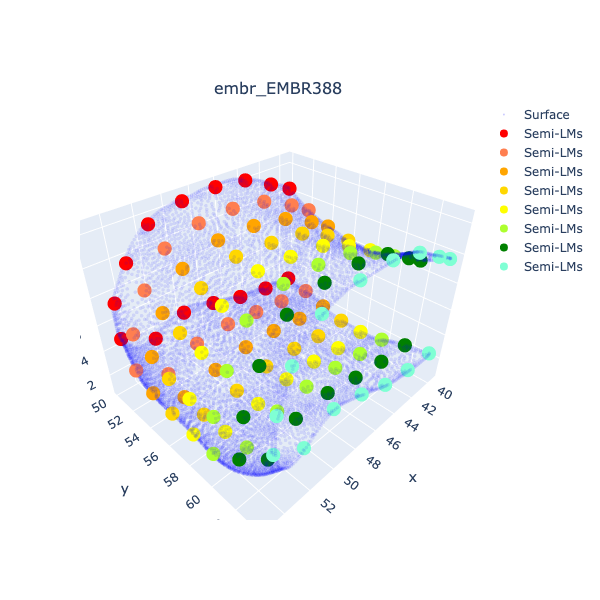

In [67]:
id = 18
# id = 60
check_file = f'{OUT_N_DIR}/check/{specimen[id]}.png'
mesh = pv.read(f"{DATA_DIR}/{specimen[id]}.vtk")
points = mesh.points

sample = LMs[id,:,:]
print(sample.shape)

fig = make_subplots(rows=1, cols=3)

# Add traces
# subplot 1
fig.add_trace(go.Scatter3d(x=points[:,0], y=points[:,1], z=points[:,2], 
                    mode='markers', marker=dict(color='blue', opacity=0.1, size=2),name='Template mesh'))
fig.add_trace(go.Scatter3d(x=sample[:,0], y=sample[:,1], z=sample[:,2], 
                    mode='markers', marker=dict(color='red'),name='Semi-LMs'))

fig.update_layout(height=600, width=600, title_text=specimen[id],scene = dict(
    xaxis = dict(
        backgroundcolor="rgba(0, 0, 0,0)",
        gridcolor="lightgray",
        showbackground=True,
        zerolinecolor="white",),
    yaxis = dict(
        backgroundcolor="rgba(0, 0, 0,0)",
        gridcolor="lightgray",
        showbackground=True,
        zerolinecolor="white"),
    zaxis = dict(
        backgroundcolor="rgba(0, 0, 0,0)",
        gridcolor="lightgray",
        showbackground=True,
        zerolinecolor="white",),),)
fig.show()

# plot_landmarks([mesh], [sample], (specimen[id],), [[{'type': 'scatter3d'}]], pfile=None, show=True)

from IPython.display import Image
Image(check_file)